In [1]:
import os
cwd = os.getcwd()
os.chdir('./recommenders/')

In [16]:
from recommenders.get_cdlm_scores import generate_cdlm_score, generate_mention_representations, generate_regressor_score
from recommenders.train_regressor import train_regressor
from recommenders.featurization import Featurizer

In [6]:
data_path = './data/ecb/mentions/'
out_folder = './data/ecb/cdlm/'
splits = ['dev', 'train', 'test']
config_file_path = './config_pairwise_long_reg_span.json'

In [8]:
# Preprocessing

import json
from recommenders.featurization import generate_tfidf_map, generate_related_words, generate_sent_2_ent

tfidf_path = out_folder + '/tfidf.pkl'
related_words_map_path = out_folder + '/related_words_map.pkl'
sent2ent_map_path = out_folder + '/sent2ent.pkl'

all_data = {}
all_events = []
all_entities = []
for split in splits:
    split_path = data_path + '/%s.json'%split
    split_data = json.load(open(split_path))
    all_data = {**all_data, **split_data}

    eve_split_path = data_path + '/%s_events.json'%split
    eve_data = json.load(open(eve_split_path))
    all_events.extend(eve_data)
    
    ent_data = json.load(open(data_path + '/%s_entities.json'%split))
    all_entities.extend(ent_data)

generate_tfidf_map(all_data, tfidf_path)
generate_related_words(all_events, related_words_map_path)
generate_sent_2_ent(all_entities, sent2ent_map_path)

100%|██████████| 6833/6833 [00:00<00:00, 118476.89it/s]


In [75]:
from collections import defaultdict
import spacy
nlp = spacy.load("en_core_web_sm")

sent2tok_map = defaultdict(list)
for doc, data in all_data.items():
#     print(data)
    for d in data:
        sent_id = doc + '_' + str(d[0])
        word = d[2].lower()
        sent2tok_map[sent_id].append(word)

sentence_string_map = {s_id: ' '.join(words) for s_id, words in sent2tok_map.items()}

sent_token_spacy_map = {}
for sent_id, sentence in sentence_string_map.items():
    sentence_nlp = nlp(sentence)
    tokens = [tok.lemma_ for tok in sentence_nlp if not tok.is_stop and not tok.is_punct]
    sent_token_spacy_map[sent_id] = tokens

# sent2tok_map

In [77]:
pickle.dump(sent_token_spacy_map, open('sent2tok_map.pkl', 'wb'))

In [9]:
# Generate Contextualized Mention Representations

# Download this at: https://drive.google.com/drive/folders/1bVSI3VPAvcIixrclkZyTHDXi7bamg93b?usp=sharing
model_dir = './models/cdlm2/checkpoint_8/'

context_vector_map_path = out_folder + '/context_vector_map.pkl'
if not os.path.exists(context_vector_map_path):
    generate_mention_representations(config_file_path, model_dir, splits, out_folder, num_gpus=2, batch_size=12)

In [10]:
featurizer = Featurizer(tfidf_path, related_words_map_path, context_vector_map_path, sent2ent_map_path)

In [13]:
# Train Regressor

model_stat_dict_path = os.path.join(out_folder, 'regressor.chk')

if not os.path.exists(model_stat_dict_path):
    train_regressor(config_file_path, out_folder)

In [157]:
# Generate Scores From the Regressor For Dev and Test

regressor_scores_path_test = out_folder + '/regressor_score_data_%s.pkl' % "test"
regressor_scores_path_dev = out_folder + '/regressor_score_data_%s.pkl' % "dev"

if not os.path.exists(regressor_scores_path_test):
    generate_regressor_score(config_file_path,
                             model_stat_dict_path,
                             'test', out_folder)

if not os.path.exists(regressor_scores_path_dev):
    generate_regressor_score(config_file_path,
                             model_stat_dict_path,
                             'dev', out_folder)

In [18]:
# Generate Scores From the CDLM System For Dev and Test

cdlm_scores_path_test = out_folder + '/cdlm_score_data_%s.pkl'%'test'
cdlm_scores_path_dev = out_folder + '/cdlm_score_data_%s.pkl'%'dev'

if not os.path.exists(cdlm_scores_path_test):
    generate_cdlm_score(config_file_path, model_dir, 'test', out_folder, num_gpus=4, batch_size = 150)
    
if not os.path.exists(cdlm_scores_path_dev):
    generate_cdlm_score(config_file_path, model_dir, 'dev', out_folder, num_gpus=4, batch_size = 150)


In [107]:
import importlib
importlib.reload(recommenders.incremental_clustering)

<module 'recommenders.incremental_clustering' from '/media/rehan/work/workspace/acl_submission/CDLM/recommenders/incremental_clustering.py'>

In [108]:
import recommenders.incremental_clustering
from recommenders.incremental_clustering import comparison_anaylis

In [109]:
ks = [2, 2.5, 3, 3.5, 4, 4.5, 5]

In [156]:
# Dev score for threshold = 0.0001 for CDLM method

comparison_anaylis('./data/ecb/', 'dev', sent_token_spacy_map, cdlm_scores_path_dev, ks=[10], threshold=0.0001)

clusters 991


Clustering: 152it [00:00, 518.50it/s]

mention: 1245
within events 991



Clustering: 155it [00:00, 692.89it/s]
Clustering: 147it [00:00, 468.89it/s]
Clustering: 102it [00:00, 712.01it/s]
Clustering: 115it [00:00, 531.25it/s]
Clustering: 142it [00:00, 390.97it/s]
Clustering: 110it [00:00, 548.36it/s]
Clustering: 68it [00:00, 716.19it/s]


0.7154046997389034
[(10, 0.9501000000000001, 0.7154046997389034, 2692)]


[(10, 0.9501000000000001, 0.7154046997389034, 2692)]

In [158]:
# Dev score for threshold = 0.369 for Regressor method

comparison_anaylis('./data/ecb/', 'dev', sent_token_spacy_map, regressor_scores_path_dev, ks=[10], threshold=0.369)

clusters 991


Clustering: 152it [00:00, 508.90it/s]

mention: 1245
within events 991



Clustering: 155it [00:00, 683.89it/s]
Clustering: 147it [00:00, 467.12it/s]
Clustering: 102it [00:00, 690.35it/s]
Clustering: 115it [00:00, 529.93it/s]
Clustering: 142it [00:00, 423.74it/s]
Clustering: 110it [00:00, 573.93it/s]
Clustering: 68it [00:00, 848.92it/s]


0.643348623853211
[(10, 0.9725, 0.643348623853211, 5478)]


[(10, 0.9725, 0.643348623853211, 5478)]

In [148]:
split = 'test'
comp_cdlm_thres_10_to_minus_4 = comparison_anaylis('./data/ecb/', split, sent_token_spacy_map, cdlm_scores_path_test, ks=ks, threshold=0.0001)

clusters 1403


Clustering: 117it [00:00, 763.99it/s]
Clustering: 80it [00:00, 790.72it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 387.77it/s]
Clustering: 67it [00:00, 622.47it/s]
Clustering: 83it [00:00, 754.88it/s]
Clustering: 89it [00:00, 657.88it/s]
Clustering: 169it [00:00, 369.33it/s]
Clustering: 92it [00:00, 606.18it/s]
Clustering: 200it [00:00, 335.16it/s]
Clustering: 227it [00:00, 293.59it/s]
Clustering: 188it [00:00, 337.99it/s]


0.5374753451676528


Clustering: 117it [00:00, 743.66it/s]
Clustering: 78it [00:00, 764.75it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 378.73it/s]
Clustering: 67it [00:00, 648.30it/s]
Clustering: 83it [00:00, 786.07it/s]
Clustering: 89it [00:00, 686.66it/s]
Clustering: 169it [00:00, 403.12it/s]
Clustering: 92it [00:00, 719.07it/s]
Clustering: 200it [00:00, 337.28it/s]
Clustering: 227it [00:00, 296.25it/s]
Clustering: 188it [00:00, 338.81it/s]


0.5473372781065089


Clustering: 117it [00:00, 780.48it/s]
Clustering: 80it [00:00, 785.89it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 397.51it/s]
Clustering: 67it [00:00, 645.59it/s]
Clustering: 83it [00:00, 704.98it/s]
Clustering: 89it [00:00, 676.53it/s]
Clustering: 169it [00:00, 401.68it/s]
Clustering: 92it [00:00, 704.97it/s]
Clustering: 200it [00:00, 341.19it/s]
Clustering: 227it [00:00, 304.82it/s]
Clustering: 188it [00:00, 345.06it/s]


0.5591715976331361


Clustering: 117it [00:00, 811.84it/s]
Clustering: 80it [00:00, 788.66it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 403.80it/s]
Clustering: 67it [00:00, 648.37it/s]
Clustering: 83it [00:00, 784.00it/s]
Clustering: 89it [00:00, 687.89it/s]
Clustering: 169it [00:00, 398.90it/s]
Clustering: 92it [00:00, 707.57it/s]
Clustering: 200it [00:00, 341.21it/s]
Clustering: 227it [00:00, 304.13it/s]
Clustering: 188it [00:00, 352.02it/s]


0.5621301775147929


Clustering: 117it [00:00, 765.68it/s]
Clustering: 80it [00:00, 785.41it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 394.19it/s]
Clustering: 67it [00:00, 646.92it/s]
Clustering: 83it [00:00, 789.00it/s]
Clustering: 89it [00:00, 676.15it/s]
Clustering: 169it [00:00, 400.17it/s]
Clustering: 92it [00:00, 696.01it/s]
Clustering: 200it [00:00, 336.20it/s]
Clustering: 227it [00:00, 304.37it/s]
Clustering: 188it [00:00, 349.96it/s]


0.5650887573964497


Clustering: 117it [00:00, 772.84it/s]
Clustering: 80it [00:00, 793.50it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 403.77it/s]
Clustering: 67it [00:00, 660.76it/s]
Clustering: 83it [00:00, 790.42it/s]
Clustering: 89it [00:00, 686.74it/s]
Clustering: 169it [00:00, 402.52it/s]
Clustering: 92it [00:00, 719.02it/s]
Clustering: 200it [00:00, 340.60it/s]
Clustering: 227it [00:00, 302.31it/s]
Clustering: 188it [00:00, 349.11it/s]


0.5660749506903353


Clustering: 117it [00:00, 763.81it/s]
Clustering: 80it [00:00, 787.13it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 401.10it/s]
Clustering: 67it [00:00, 654.30it/s]
Clustering: 83it [00:00, 779.74it/s]
Clustering: 89it [00:00, 686.01it/s]
Clustering: 169it [00:00, 403.11it/s]
Clustering: 92it [00:00, 713.07it/s]
Clustering: 200it [00:00, 342.37it/s]
Clustering: 227it [00:00, 306.65it/s]
Clustering: 188it [00:00, 348.96it/s]


0.5670611439842209
[(2, 0.9147, 0.5374753451676528, 1793), (2.5, 0.9297, 0.5473372781065089, 1915), (3, 0.9515, 0.5591715976331361, 2406), (3.5, 0.9548000000000001, 0.5621301775147929, 2481), (4, 0.9598, 0.5650887573964497, 2888), (4.5, 0.9615, 0.5660749506903353, 2951), (5, 0.9632, 0.5670611439842209, 3269)]


In [149]:
comp_cdlm_no_thres = comparison_anaylis('./data/ecb/', split, sent_token_spacy_map, cdlm_scores_path_test, ks=[2, 2.5, 3, 3.5, 4, 4.5, 5], threshold=0.0)

clusters 1403


Clustering: 117it [00:00, 768.75it/s]
Clustering: 80it [00:00, 797.10it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 394.96it/s]
Clustering: 67it [00:00, 695.79it/s]
Clustering: 83it [00:00, 796.85it/s]
Clustering: 89it [00:00, 679.86it/s]
Clustering: 169it [00:00, 409.11it/s]
Clustering: 92it [00:00, 721.78it/s]
Clustering: 200it [00:00, 349.04it/s]
Clustering: 227it [00:00, 304.59it/s]
Clustering: 188it [00:00, 351.05it/s]


0.41260315078769694


Clustering: 117it [00:00, 795.10it/s]
Clustering: 79it [00:00, 788.49it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 392.82it/s]
Clustering: 67it [00:00, 638.56it/s]
Clustering: 83it [00:00, 770.60it/s]
Clustering: 89it [00:00, 665.94it/s]
Clustering: 169it [00:00, 396.15it/s]
Clustering: 92it [00:00, 710.55it/s]
Clustering: 200it [00:00, 341.18it/s]
Clustering: 227it [00:00, 300.81it/s]
Clustering: 188it [00:00, 343.07it/s]


0.4253563390847712


Clustering: 117it [00:00, 752.08it/s]
Clustering: 0it [00:00, ?it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 403.34it/s]
Clustering: 67it [00:00, 681.92it/s]
Clustering: 83it [00:00, 775.64it/s]
Clustering: 89it [00:00, 669.09it/s]
Clustering: 169it [00:00, 399.26it/s]
Clustering: 92it [00:00, 728.23it/s]
Clustering: 200it [00:00, 343.07it/s]
Clustering: 227it [00:00, 307.41it/s]
Clustering: 188it [00:00, 337.64it/s]


0.43135783945986494


Clustering: 117it [00:00, 725.46it/s]
Clustering: 80it [00:00, 790.04it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 401.45it/s]
Clustering: 67it [00:00, 644.52it/s]
Clustering: 83it [00:00, 786.40it/s]
Clustering: 89it [00:00, 686.12it/s]
Clustering: 169it [00:00, 402.41it/s]
Clustering: 92it [00:00, 719.98it/s]
Clustering: 200it [00:00, 339.34it/s]
Clustering: 227it [00:00, 305.00it/s]
Clustering: 188it [00:00, 347.49it/s]


0.43435858964741186


Clustering: 117it [00:00, 750.82it/s]
Clustering: 79it [00:00, 779.76it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 395.58it/s]
Clustering: 67it [00:00, 640.31it/s]
Clustering: 83it [00:00, 778.02it/s]
Clustering: 89it [00:00, 687.82it/s]
Clustering: 169it [00:00, 403.17it/s]
Clustering: 92it [00:00, 716.38it/s]
Clustering: 200it [00:00, 344.61it/s]
Clustering: 227it [00:00, 303.45it/s]
Clustering: 188it [00:00, 347.12it/s]


0.436609152288072


Clustering: 117it [00:00, 763.89it/s]
Clustering: 79it [00:00, 788.44it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 402.23it/s]
Clustering: 67it [00:00, 653.61it/s]
Clustering: 83it [00:00, 791.45it/s]
Clustering: 89it [00:00, 698.57it/s]
Clustering: 169it [00:00, 402.48it/s]
Clustering: 92it [00:00, 720.77it/s]
Clustering: 200it [00:00, 346.26it/s]
Clustering: 227it [00:00, 305.14it/s]
Clustering: 188it [00:00, 349.84it/s]


0.44036009002250565


Clustering: 117it [00:00, 818.02it/s]
Clustering: 79it [00:00, 781.92it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 399.88it/s]
Clustering: 67it [00:00, 685.86it/s]
Clustering: 83it [00:00, 791.79it/s]
Clustering: 89it [00:00, 698.09it/s]
Clustering: 169it [00:00, 400.87it/s]
Clustering: 92it [00:00, 765.88it/s]
Clustering: 200it [00:00, 344.07it/s]
Clustering: 227it [00:00, 304.70it/s]
Clustering: 188it [00:00, 348.57it/s]


0.44036009002250565
[(2, 0.9229999999999999, 0.41260315078769694, 2664), (2.5, 0.9498000000000001, 0.4253563390847712, 3058), (3, 0.9648, 0.43135783945986494, 3979), (3.5, 0.9715, 0.43435858964741186, 4342), (4, 0.9749, 0.436609152288072, 5277), (4.5, 0.9832, 0.44036009002250565, 5657), (5, 0.9832, 0.44036009002250565, 6562)]


In [150]:
regressor_no_thres = comparison_anaylis('./data/ecb/', 'test', sent_token_spacy_map, regressor_scores_path_test, ks=ks, threshold=0.0)

clusters 1403


Clustering: 117it [00:00, 765.41it/s]
Clustering: 79it [00:00, 783.45it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 401.66it/s]
Clustering: 67it [00:00, 653.67it/s]
Clustering: 83it [00:00, 760.45it/s]
Clustering: 89it [00:00, 675.60it/s]
Clustering: 169it [00:00, 410.33it/s]
Clustering: 92it [00:00, 709.87it/s]
Clustering: 200it [00:00, 347.88it/s]
Clustering: 227it [00:00, 311.09it/s]
Clustering: 188it [00:00, 346.14it/s]


0.4111027756939235


Clustering: 117it [00:00, 743.31it/s]
Clustering: 78it [00:00, 776.69it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 394.49it/s]
Clustering: 67it [00:00, 674.97it/s]
Clustering: 83it [00:00, 760.23it/s]
Clustering: 89it [00:00, 668.27it/s]
Clustering: 169it [00:00, 402.82it/s]
Clustering: 92it [00:00, 696.86it/s]
Clustering: 200it [00:00, 341.98it/s]
Clustering: 227it [00:00, 307.12it/s]
Clustering: 188it [00:00, 344.13it/s]


0.4156039009752438


Clustering: 117it [00:00, 753.63it/s]
Clustering: 79it [00:00, 781.97it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 394.32it/s]
Clustering: 67it [00:00, 663.12it/s]
Clustering: 83it [00:00, 748.16it/s]
Clustering: 89it [00:00, 675.71it/s]
Clustering: 169it [00:00, 399.53it/s]
Clustering: 92it [00:00, 687.88it/s]
Clustering: 200it [00:00, 340.27it/s]
Clustering: 227it [00:00, 303.48it/s]
Clustering: 188it [00:00, 339.33it/s]


0.4223555888972243


Clustering: 117it [00:00, 752.11it/s]
Clustering: 79it [00:00, 784.45it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 390.97it/s]
Clustering: 67it [00:00, 628.81it/s]
Clustering: 83it [00:00, 746.26it/s]
Clustering: 89it [00:00, 684.26it/s]
Clustering: 169it [00:00, 400.69it/s]
Clustering: 92it [00:00, 691.74it/s]
Clustering: 200it [00:00, 341.18it/s]
Clustering: 227it [00:00, 300.44it/s]
Clustering: 188it [00:00, 338.01it/s]


0.42460615153788445


Clustering: 117it [00:00, 774.47it/s]
Clustering: 79it [00:00, 782.48it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 396.71it/s]
Clustering: 67it [00:00, 641.47it/s]
Clustering: 83it [00:00, 749.89it/s]
Clustering: 89it [00:00, 675.89it/s]
Clustering: 169it [00:00, 392.65it/s]
Clustering: 92it [00:00, 701.67it/s]
Clustering: 200it [00:00, 335.77it/s]
Clustering: 227it [00:00, 304.87it/s]
Clustering: 188it [00:00, 346.15it/s]


0.42760690172543137


Clustering: 117it [00:00, 771.46it/s]
Clustering: 80it [00:00, 790.64it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 395.43it/s]
Clustering: 67it [00:00, 613.24it/s]
Clustering: 83it [00:00, 768.93it/s]
Clustering: 89it [00:00, 688.56it/s]
Clustering: 169it [00:00, 405.56it/s]
Clustering: 92it [00:00, 705.76it/s]
Clustering: 200it [00:00, 345.93it/s]
Clustering: 227it [00:00, 306.82it/s]
Clustering: 188it [00:00, 340.12it/s]


0.4291072768192048


Clustering: 117it [00:00, 812.97it/s]
Clustering: 80it [00:00, 790.53it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 405.22it/s]
Clustering: 67it [00:00, 655.99it/s]
Clustering: 83it [00:00, 776.49it/s]
Clustering: 89it [00:00, 699.33it/s]
Clustering: 169it [00:00, 389.95it/s]
Clustering: 92it [00:00, 607.47it/s]
Clustering: 200it [00:00, 343.91it/s]
Clustering: 227it [00:00, 306.48it/s]
Clustering: 188it [00:00, 348.64it/s]


0.43360840210052515
[(2, 0.9163, 0.4111027756939235, 2664), (2.5, 0.9264, 0.4156039009752438, 3066), (3, 0.9448000000000001, 0.4223555888972243, 3979), (3.5, 0.9498000000000001, 0.42460615153788445, 4342), (4, 0.9565, 0.42760690172543137, 5277), (4.5, 0.9581000000000001, 0.4291072768192048, 5645), (5, 0.9682, 0.43360840210052515, 6562)]


In [159]:
regressor_threshold_508 = comparison_anaylis('./data/ecb/', 'test', sent_token_spacy_map, regressor_scores_path_test, ks=ks, threshold=0.369)

clusters 1403


Clustering: 117it [00:00, 771.87it/s]
Clustering: 80it [00:00, 789.05it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 395.45it/s]
Clustering: 67it [00:00, 636.66it/s]
Clustering: 83it [00:00, 763.69it/s]
Clustering: 89it [00:00, 638.83it/s]
Clustering: 169it [00:00, 399.24it/s]
Clustering: 92it [00:00, 696.45it/s]
Clustering: 200it [00:00, 349.39it/s]
Clustering: 227it [00:00, 307.04it/s]
Clustering: 188it [00:00, 341.75it/s]


0.502803738317757


Clustering: 117it [00:00, 743.77it/s]
Clustering: 79it [00:00, 789.46it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 395.71it/s]
Clustering: 67it [00:00, 641.57it/s]
Clustering: 83it [00:00, 738.72it/s]
Clustering: 89it [00:00, 636.03it/s]
Clustering: 169it [00:00, 397.28it/s]
Clustering: 92it [00:00, 691.15it/s]
Clustering: 200it [00:00, 342.16it/s]
Clustering: 227it [00:00, 300.37it/s]
Clustering: 188it [00:00, 339.12it/s]


0.5102803738317757


Clustering: 117it [00:00, 733.12it/s]
Clustering: 0it [00:00, ?it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 399.07it/s]
Clustering: 67it [00:00, 650.47it/s]
Clustering: 83it [00:00, 750.71it/s]
Clustering: 89it [00:00, 657.70it/s]
Clustering: 169it [00:00, 399.11it/s]
Clustering: 92it [00:00, 710.03it/s]
Clustering: 200it [00:00, 345.22it/s]
Clustering: 227it [00:00, 303.94it/s]
Clustering: 188it [00:00, 338.83it/s]


0.5149532710280373


Clustering: 117it [00:00, 761.48it/s]
Clustering: 79it [00:00, 786.38it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 396.53it/s]
Clustering: 67it [00:00, 639.87it/s]
Clustering: 83it [00:00, 742.67it/s]
Clustering: 89it [00:00, 644.30it/s]
Clustering: 169it [00:00, 397.01it/s]
Clustering: 92it [00:00, 698.54it/s]
Clustering: 200it [00:00, 342.47it/s]
Clustering: 227it [00:00, 300.10it/s]
Clustering: 188it [00:00, 341.87it/s]


0.516822429906542


Clustering: 117it [00:00, 820.85it/s]
Clustering: 80it [00:00, 789.56it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 401.29it/s]
Clustering: 67it [00:00, 645.97it/s]
Clustering: 83it [00:00, 734.27it/s]
Clustering: 89it [00:00, 635.04it/s]
Clustering: 169it [00:00, 393.45it/s]
Clustering: 92it [00:00, 692.44it/s]
Clustering: 200it [00:00, 345.86it/s]
Clustering: 227it [00:00, 304.86it/s]
Clustering: 188it [00:00, 346.22it/s]


0.5186915887850467


Clustering: 117it [00:00, 766.07it/s]
Clustering: 79it [00:00, 779.60it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 396.48it/s]
Clustering: 67it [00:00, 640.11it/s]
Clustering: 83it [00:00, 750.65it/s]
Clustering: 89it [00:00, 645.80it/s]
Clustering: 169it [00:00, 392.05it/s]
Clustering: 92it [00:00, 704.76it/s]
Clustering: 200it [00:00, 342.17it/s]
Clustering: 227it [00:00, 288.55it/s]
Clustering: 188it [00:00, 338.96it/s]


0.5186915887850467


Clustering: 117it [00:00, 811.64it/s]
Clustering: 79it [00:00, 781.94it/s]

mention: 1780
within events 1403


Clustering: 171it [00:00, 398.21it/s]
Clustering: 67it [00:00, 679.51it/s]
Clustering: 83it [00:00, 756.34it/s]
Clustering: 89it [00:00, 650.32it/s]
Clustering: 169it [00:00, 399.73it/s]
Clustering: 92it [00:00, 703.19it/s]
Clustering: 200it [00:00, 344.02it/s]
Clustering: 227it [00:00, 303.26it/s]
Clustering: 188it [00:00, 346.91it/s]


0.5233644859813084
[(2, 0.9013, 0.502803738317757, 1992), (2.5, 0.9147, 0.5102803738317757, 2144), (3, 0.9247, 0.5149532710280373, 2790), (3.5, 0.9279999999999999, 0.516822429906542, 2910), (4, 0.9314, 0.5186915887850467, 3482), (4.5, 0.9314, 0.5186915887850467, 3561), (5, 0.9414, 0.5233644859813084, 4089)]


In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import matplotlib.font_manager as font_manager

matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0
ns = [2, 2.5, 3, 3.5, 4, 4.5, 5, ]
ns_no_thres = [2, 2.5, 3, 3.5, 4, 4.5, 5, ]

def round(results, ns=ns):
    results =  [[res[0]] + [np.round(r, 4) for r in res[1:]] for res in results if res[0] in ns]
    for res in results:
        if int(res[1]/10) > 0:
            res[1] = res[1]*100
    return results

In [153]:
comp_cdlm_no_thres = round(comp_cdlm_no_thres, ns=ns_no_thres)
# comp_cdlm_thres_10_to_minus_5 = round(comp_cdlm_thres_10_to_minus_5)
comp_cdlm_thres_10_to_minus_4 = round(comp_cdlm_thres_10_to_minus_4)

regressor_no_thres = round(regressor_no_thres)
regressor_threshold_508 = round(regressor_threshold_508)

In [139]:
%matplotlib inline

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5]


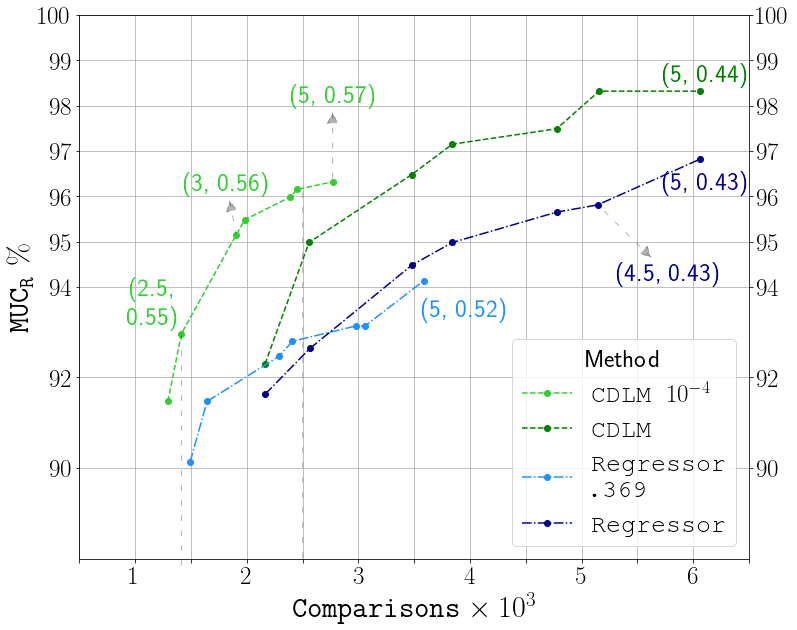

In [170]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, LogFormatter, LogLocator, FuncFormatter

def get_power_rep(val):
    log_10 = int(np.log10(val))
    pow_10 = np.power(10, log_10)
    num_decimal = val/pow_10
    
    return '$%.0f'%num_decimal + 'x10^%d$'%log_10

plt.rcParams["figure.figsize"] = (12,10)
plt.rcParams.update({'font.size': 25})
plt.rcParams['text.usetex'] = True


fig, ax = plt.subplots()

def annotate_normal(res, xytext=(10, -35), color='black', label=None):
    
    n, y, p, x = res
    if label == None:
        label = '(%s, %.2f)'%(n, p)

    plt.annotate(
        label,
        (x, y),
        color=color,
        textcoords='offset points',
        xytext=xytext,
        ha='center',
        fontsize=anno_font_size
    )

    
def annotate_arrow(res, xytext=(0, 60), label=None, arrow_style='<|-', color='black', alpha=1.0):
    
    n, y, p, x = res
    if label == None:
        label = '(%s, %.2f)'%(n, p)
    
    arrowprops=dict(arrowstyle= arrow_style,
                    ls=(0, (5, 10)),
                             color='black',
                    alpha = 0.3
                             )
    
    plt.annotate(
        label,
        (x, y),
        color=color,
        textcoords='offset points',
        xytext=xytext,
        ha='center',
        arrowprops=arrowprops,
        fontsize=anno_font_size,
        
    )


    
def plot_label(ns, xs, ys, ps, label, style, color):
    at_ns = ['@%d'%n for n in ns]

    xticks = [i/2 for i in range(2, 26)]
    print(xticks)
    xticks_labels = ['$%d$'%i if j%2==1 else '' for j, i in enumerate(xticks)]
#     xticks.insert(2, 2500)
    xticks = np.array(xticks)*1000
#     xticks.remove(11000)
#     yticks = [80, 82, 84,86, 88, 90, 92, 94, 95, 96, 97, 98, 99, 100]
    
    yticks = [90, 92, 94, 95, 96, 97, 98, 99, 100]
    
    ax.set_ylim(ymin=88, ymax=100)

    ax.plot(xs, ys, style, label=label, color=color)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)

    xticks = ax.xaxis.get_major_ticks()
    
    hide_ticks = np.array([-2, -4])
    for h in hide_ticks:
        xticks[h].label1.set_visible(False)

    ax.set_yticks(yticks)

    ax.set_xlim(xmin=1000, xmax=7000)

anno_font_size = 25


c1 = 'green'
c2 = 'limegreen'
    
def plot(results, label, style, color='black'):
    indices = [2, 2.5, 3, 3.5, 4, 4.5, 5, ]
    plot_results = [res for res in results if res[0] in indices]
    ns, ys, ps, xs = zip(*plot_results)
    plot_label(ns, xs, ys, ps, label, style, color)






plot(comp_cdlm_thres_10_to_minus_4, r'{\fontfamily{qcr}\selectfont CDLM~\ensuremath{10^{-4}}}', 'o--', color=c2)
# annotate_normal(comp_cdlm_thres_10_to_minus_4[0])
n, y, p, x = comp_cdlm_thres_10_to_minus_4[1]
annotate_normal(comp_cdlm_thres_10_to_minus_4[1],color=c2, xytext=(-30, 10), label='(%s,\n%.2f)'%(n, p))
annotate_arrow(comp_cdlm_thres_10_to_minus_4[2], color=c2, xytext=(-10,45))
annotate_arrow(comp_cdlm_thres_10_to_minus_4[-1], color=c2, xytext=(0, 80))

annotate_arrow(comp_cdlm_thres_10_to_minus_4[1], 
               color=c2, 
               arrow_style= '-', 
               label='', 
               xytext=(0, -234), alpha=0.3)

n, y, p, x = comp_cdlm_thres_10_to_minus_4[-2]
x = x + 50
res_new = (n, y, p, x)

annotate_arrow(res_new, 
               color=c2, 
               arrow_style= '-', 
               label='', 
               xytext=(0, -370), alpha=0.3)



plot(comp_cdlm_no_thres, r'{\fontfamily{qcr}\selectfont CDLM}', 'o--', c1)
# annotate_normal(comp_cdlm_no_thres[0], xytext=(50, -25))
# annotate_arrow(comp_cdlm_no_thres[1], xytext=(65, -100), color=c1)


annotate_normal(comp_cdlm_no_thres[-1], color=c1, xytext=(5, 10))

c3 = 'dodgerblue'
c4 = 'darkblue'

plot(regressor_threshold_508, r'{\fontfamily{qcr}\selectfont Regressor}' + '\n' + r'{\fontfamily{qcr}\selectfont .369}'
     , 'o-.', color='dodgerblue')
annotate_normal(regressor_threshold_508[-1], color=c3, xytext=(40, -35))

plot(regressor_no_thres, r'{\fontfamily{qcr}\selectfont Regressor}', 'o-.', color='darkblue')
annotate_normal(regressor_no_thres[-1], color=c4, xytext=(5, -30))

n, y, p, x = regressor_no_thres[-2]
annotate_arrow(regressor_no_thres[-2], color=c4, xytext=(70, -75), alpha=0.3)


# x_no_thres_point = (x_no_thres, 0.95)

# no_thres_2 = np.round((2, 0.9247, 0.41335333833458365, 2660), 2)
# # print(no_thres_2)
# plt.plot(no_thres_2[-1], no_thres_2[1], 'go')
ax.tick_params(right=True,labelright=True)
# plt.xlabel(r'$\mathtt{Comparisons}\times10^{3}$', fontsize=30)
plt.xlabel(r'$\mathtt{Comparisons}\times10^{3}$', fontsize=30)
plt.ylabel(r'$\mathtt{MUC_R}~\%$', fontsize=30)

font = font_manager.FontProperties(weight='bold',
                                   style='normal', size=25)

plt.legend(title='Method', loc=4, prop=font)
plt.grid()
plt.savefig('muc_by_comps.eps', format='pdf', bbox_inches='tight')

In [163]:
regressor_threshold_508 = round(regressor_threshold_508)